In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
import torch
import math
import os
from PIL import Image
import numpy as np
import json

In [40]:
# Define transformations for images and masks
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the input images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the masks to match images
    transforms.ToTensor(),  # Convert masks to PyTorch tensors
])

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, image_transforms=None, mask_transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        self.images = []

        # Filter for image files and ensure corresponding masks exist
        valid_extensions = ['.jpg', '.jpeg', '.png']  # Add or remove extensions as needed
        self.images = [f for f in os.listdir(image_dir) 
                       if any(f.endswith(ext) for ext in valid_extensions)
                       and os.path.exists(os.path.join(mask_dir, f"{f}"))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_filename = self.images[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        mask_filename = f"{img_filename}"  # Adjust based on your mask naming convention
        mask_path = os.path.join(self.mask_dir, mask_filename)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.image_transforms:
            image = self.image_transforms(image)
        if self.mask_transforms:
            mask = self.mask_transforms(mask)

        return image, mask

In [41]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float("inf")
        
    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (validation_loss + self.min_delta):
            self.counter += 1
            if self.counter > self.patience:
                return True
        return False

In [42]:
# Double convolution block
class DoubleConv(nn.Module):
    """(Convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Downsampling block
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# Upsampling block
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Output convolution block
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [43]:
class ConvLSTM(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.conv_lstm = nn.LSTMCell(input_size=(in_channels, kernel_size, kernel_size),
                                     hidden_size=(out_channels, kernel_size, kernel_size))

    def forward(self, x, cur_state):
        h_cur, c_cur = self.conv_lstm(x, cur_state)
        return h_cur, c_cur


In [44]:
# U-Net model
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [45]:
import time
# Hyperparameters
learning_rate = 1e-4
batch_size = 1
num_epochs = 10

# Load the full dataset
image_dir = '/Users/eik/Downloads/Computer Vision/Original_cropped_size'
mask_dir = '/Users/eik/Downloads/Computer Vision/Masked_cropped_size'
full_dataset = SegmentationDataset(image_dir, mask_dir, image_transforms, mask_transforms)

# Split the dataset
total_size = len(full_dataset)
print(total_size)
val_size = int(0.3 * total_size)  # Calculate 30% of the total size for validation
train_size = total_size - val_size  # The rest for training
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Prepare data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Model, optimizer, and loss function
model = UNet(n_channels=3, n_classes=1).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = BCEWithLogitsLoss()

# Initialize performance metrics
losses = []
accuracies = []
val_losses = []
val_accs = []

# Initialize earlystopper
early_stopper = EarlyStopping(patience=1, min_delta=0)
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    correct_pixels = 0
    total_pixels = 0

    for images, masks in train_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        total_loss += loss.item()

        # Calculating accuracy
        predicted = torch.sigmoid(outputs) > 0.5  # Convert output probabilities to binary predictions (0 or 1)
        correct_pixels += (predicted == masks).sum().item()
        total_pixels += torch.numel(masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = total_loss / len(train_dataloader)
    epoch_acc = correct_pixels / total_pixels * 100

    # Append metrics to lists
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    # Validate the results
    val_total_loss = 0
    val_correct_pixels = 0
    val_total_pixels = 0
    with torch.no_grad():
        for val_images, val_masks in val_dataloader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)
    
            # Forward pass
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_masks)
            val_total_loss += val_loss.item()
    
            # Calculating accuracy
            val_predicted = torch.sigmoid(val_outputs) > 0.5  # Convert output probabilities to binary predictions (0 or 1)
            val_correct_pixels += (val_predicted == val_masks).sum().item()
            val_total_pixels += torch.numel(val_masks)
    
        val_epoch_loss = val_total_loss / len(val_dataloader)
        val_epoch_acc = val_correct_pixels / val_total_pixels * 100
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, val_Loss: {val_epoch_loss:.4f}, val_acc: {val_epoch_acc:.2f}%")

    if early_stopper.early_stop(val_epoch_loss):
        print(f"early stopped at epoch {epoch+1}")
        break
# Saving the metrics
output_dir = "/Users/eik/Downloads/Computer Vision/"
metrics = {"train_loss": losses, "train_accuracy": accuracies, "val_loss": val_losses, "val_accuracy":val_accs }
metrics_path = 'Recurrent_U_Net_performance_metrics.json'
metrics_dir = os.path.join(output_dir, metrics_path)
with open(metrics_dir, 'w') as f:
    json.dump(metrics, f)  

    
# Save model and optimizer
model_path = 'Recurrent_path_to_save_model.pth' # Change your path and path name accordingly
model_path = os.path.join(output_dir, model_path)
optimizer_path = 'Recurrent_path_to_save_optimizer.pth' # Change your path and path name accordingly
optimizer_path = os.path.join(output_dir, optimizer_path)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_path)

# Optionally, save optimizer separately if needed
torch.save(optimizer.state_dict(), optimizer_path)

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time} seconds.")

463


KeyboardInterrupt: 

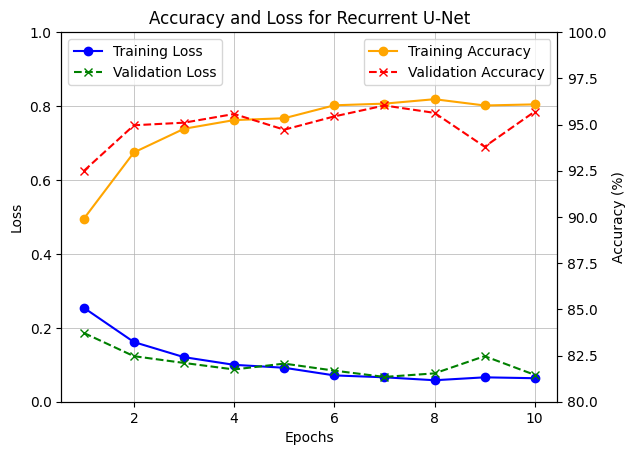

"\nplt.figure(figsize=(6, 4))\nplt.plot(epoch, training_losses, label='Training Loss', marker='o')\nplt.plot(epoch, training_accuracies, label='Training Accuracy', marker='o')\nplt.plot(epochs, validation_losses, label='Validation Loss', linestyle='--', marker='x')\nplt.plot(epochs, validation_accuracies, label='Validation Accuracy', linestyle='--', marker='x')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy and Loss')\nplt.title('Accuracy and Loss for Recurrent U-Net')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

In [2]:
import matplotlib.pyplot as plt
import matplotlib
# Epochs
epoch = list(range(1, 11))

# Training loss
training_losses = [0.2542, 0.1614, 0.1206, 0.0998, 0.0919, 0.0712, 0.0661, 0.0581, 0.0660, 0.0636]

# Training accuracy (converted to scale from 0 to 1)
training_accuracies = [89.90, 93.49, 94.77, 95.24, 95.34, 96.04, 96.13, 96.37, 96.03, 96.09]
#training_accuracies = [x / 100 for x in training_accuracies]

# Validation loss
validation_losses = [0.1861, 0.1232, 0.1049, 0.0873, 0.1031, 0.0841, 0.0671, 0.0767, 0.1233, 0.0727]

# Validation accuracy (converted to scale from 0 to 1)
validation_accuracies = [92.49, 94.96, 95.10, 95.57, 94.72, 95.44, 96.03, 95.63, 93.80, 95.70]
#validation_accuracies = [x / 100 for x in validation_accuracies]
# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot training and validation loss on the primary y-axis
ax1.plot(epoch, training_losses, color ='blue', label='Training Loss', marker='o')
ax1.plot(epoch, validation_losses, color ='green', label='Validation Loss', linestyle='--', marker='x')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_ylim([0, 1])  # Setting the limit for loss
ax1.legend(loc='upper left')

# Create a second y-axis for the accuracies
ax2 = ax1.twinx()
ax2.plot(epoch, training_accuracies, color ='orange', label='Training Accuracy', marker='o')
ax2.plot(epoch, validation_accuracies, color ='red', label='Validation Accuracy', linestyle='--', marker='x')
ax2.set_ylabel('Accuracy (%)')
ax2.set_ylim([80, 100])  # Setting the limit for accuracy
ax2.legend(loc='upper right')


# Show the plot
plt.title('Accuracy and Loss for Recurrent U-Net')
ax1.grid(True, which='both', axis='both', linestyle='-', linewidth=0.5)
plt.show()
"""
plt.figure(figsize=(6, 4))
plt.plot(epoch, training_losses, label='Training Loss', marker='o')
plt.plot(epoch, training_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, validation_losses, label='Validation Loss', linestyle='--', marker='x')
plt.plot(epochs, validation_accuracies, label='Validation Accuracy', linestyle='--', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Loss')
plt.title('Accuracy and Loss for Recurrent U-Net')
plt.legend()
plt.grid(True)
plt.show()
"""

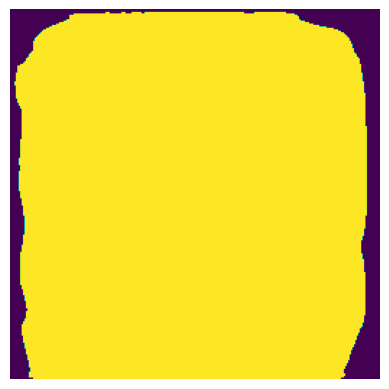

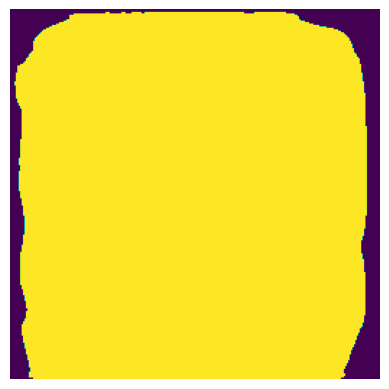

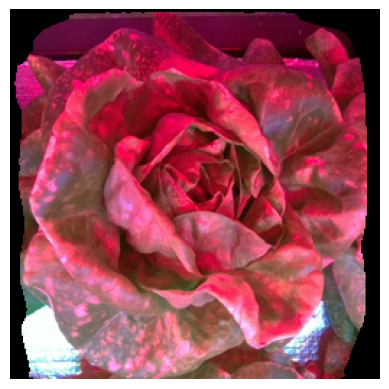

In [25]:
from PIL import Image
import os
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

# Path to the saved model and optimizer
output_dir = '/Users/eik/Downloads/Computer Vision/'  # Update with the path where you saved your model
model_path = os.path.join(output_dir, 'Recurrent_path_to_save_model.pth')
optimizer_path = os.path.join(output_dir, 'Recurrent_path_to_save_optimizer.pth')

# Assuming 'RecurrentUNet' is your model's architecture
model = UNet(n_channels=3, n_classes=1).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate) # Initialize it the same way you did before saving
#optimizer = torch.optim.Adam(model.parameters())  # Assuming you used Adam; adjust accordingly

# Load model and optimizer states
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(torch.load(optimizer_path))

# Load the original RGB image
image_path = "/Users/eik/Downloads/Computer Vision/Original_cropped_size/T_rgb_20231217_193543_17.png"
original_image = Image.open(image_path)

# Transform the image as needed for the model input
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ensure the image is resized to match the model's expected input size
    transforms.ToTensor(),
])
input_image = transform(original_image).unsqueeze(0)  # Add batch dimension

# Load and prepare the model
model.eval()  # Set the model to evaluation mode
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device)
input_image = input_image.to(device)

# Perform inference
with torch.no_grad():
    output = model(input_image)
    mask = torch.sigmoid(output)  # Sigmoid to convert outputs to probabilities
    mask = (mask > 0.5).float()  # Thresholding to create a binary mask

# Prepare mask for application to the original image
mask = mask.squeeze()  # Remove the batch dimension
mask = mask.cpu()  # Move the mask back to CPU for further processing with PIL
plt.imshow(mask)
plt.axis('off')
plt.show()

# Convert mask to 3-channel image to apply on the RGB image
mask_3channel = mask.repeat(3, 1, 1)  # Repeat the mask across 3 channels

# Resize original image and mask to the same size (if different)
original_image = original_image.resize((256, 256))  # Resizing original image if necessary
mask_image = transforms.ToPILImage()(mask)  # Convert the single-channel mask to a PIL image
mask_image = mask_image.resize(original_image.size)  # Ensure mask is the same size as the original image
plt.imshow(mask_image)
plt.axis('off')
plt.show()
# Convert PIL image to Tensor to use the mask
original_tensor = transforms.ToTensor()(original_image)
mask_3channel = transforms.ToTensor()(mask_image).repeat(3, 1, 1)  # Ensure the mask is 3-channel

# Apply the mask to the original image
final_image = original_tensor * mask_3channel  # Apply the binary mask

# Convert the result to a PIL image for saving or displaying
final_pil_image = transforms.ToPILImage()(final_image)

# Display the final image
plt.imshow(final_pil_image)
plt.axis('off')
plt.show()

# Save the final image
#final_pil_image.save('/Users/eik/Downloads/Computer Vision/T_rgb_20231217_193543_17.png')


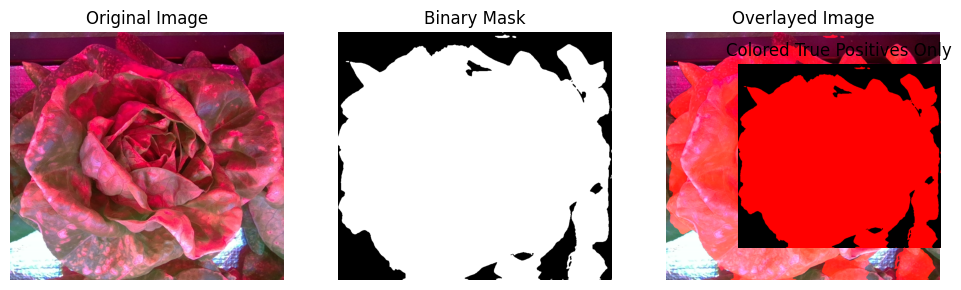

In [29]:
import torch
from PIL import Image
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt

# Assuming the paths and model setup from your provided code
output_dir = '/Users/eik/Downloads/Computer Vision/'
model_path = os.path.join(output_dir, 'Recurrent_path_to_save_model.pth')
optimizer_path = os.path.join(output_dir, 'Recurrent_path_to_save_optimizer.pth')
image_path = "/Users/eik/Downloads/Computer Vision/Original_cropped_size/T_rgb_20231217_193543_17.png"

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=1).to(device)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load the image
original_image = Image.open(image_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(original_image).unsqueeze(0).to(device)

# Predict the mask
with torch.no_grad():
    output = model(input_tensor)
    output = torch.sigmoid(output)
    predicted_mask = output.squeeze().cpu().numpy()

# Threshold the predicted mask to create a binary image
thresholded_mask = predicted_mask > 0.5  # Threshold can be adjusted

# Create an overlay of the mask on the original image
colored_mask = np.zeros((original_image.height, original_image.width, 3), dtype=np.uint8)
colored_mask[thresholded_mask] = [255, 0, 0]  # Red color for the mask

# Convert the original PIL image to an array and combine with the mask
original_image_np = np.array(original_image)
overlayed_image = np.where(colored_mask, colored_mask, original_image_np)

# Create another image where only the mask is in color and the rest is black
colored_true_positives = np.zeros_like(original_image_np)
colored_true_positives[thresholded_mask] = [255, 0, 0]  # Apply color to true positive regions

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(original_image_np)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(thresholded_mask, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(overlayed_image)
plt.title('Overlayed Image')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(colored_true_positives)
plt.title('Colored True Positives Only')
plt.axis('off')

plt.show()


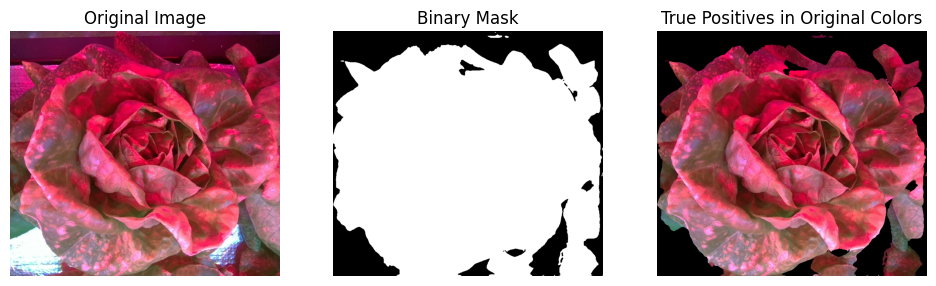

Image saved successfully at /Users/eik/Downloads/Computer Vision/recurrent-Unet_T_rgb_20231217_193543_17.png


In [32]:
import torch
from PIL import Image
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt

# Assuming the paths and model setup from your provided code
output_dir = '/Users/eik/Downloads/Computer Vision/'
model_path = os.path.join(output_dir, 'Recurrent_path_to_save_model.pth')
image_path = "/Users/eik/Downloads/Computer Vision/Original_cropped_size/T_rgb_20231217_193543_17.png"

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=1).to(device)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load the image
original_image = Image.open(image_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(original_image).unsqueeze(0).to(device)

# Predict the mask
with torch.no_grad():
    output = model(input_tensor)
    output = torch.sigmoid(output)
    predicted_mask = output.squeeze().cpu().numpy()

# Threshold the predicted mask to create a binary image
thresholded_mask = predicted_mask > 0.5  # Threshold can be adjusted

# Convert the original PIL image to an array
original_image_np = np.array(original_image)

# Create an image where only the true positive regions are in their original color and the rest is black
true_positive_colors = np.zeros_like(original_image_np)
true_positive_colors[thresholded_mask] = original_image_np[thresholded_mask]

# Display the results
plt.figure(figsize=(16, 8))
plt.subplot(1, 4, 1)
plt.imshow(original_image_np)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(thresholded_mask, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(true_positive_colors)
plt.title('True Positives in Original Colors')
plt.axis('off')

#plt.show()

# Save the figure
save_path = os.path.join(output_dir, 'recurrent-Unet_T_rgb_20231217_193543_17.png')  # Change the extension to .jpg if you prefer JPEG
plt.savefig(save_path)
plt.show()

print(f"Image saved successfully at {save_path}")


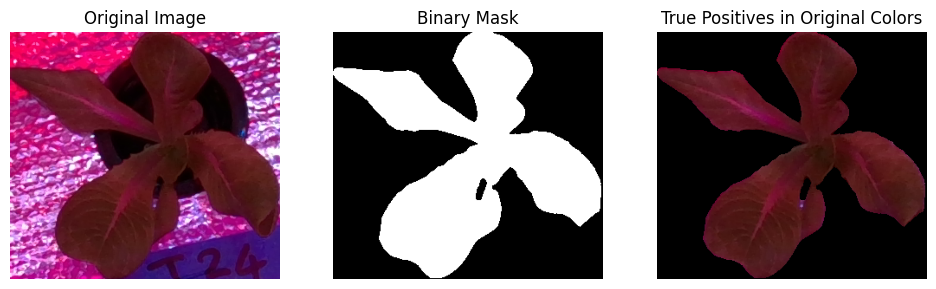

Image saved successfully at /Users/eik/Downloads/Computer Vision/recurrent-Unet_T_rgb_20231118_151439_9.png


In [34]:
import torch
from PIL import Image
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt

# Assuming the paths and model setup from your provided code
output_dir = '/Users/eik/Downloads/Computer Vision/'
model_path = os.path.join(output_dir, 'Recurrent_path_to_save_model.pth')
image_path = "/Users/eik/Downloads/Computer Vision/Original_cropped_size/T_rgb_20231118_151439_9.png"

# Load the model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=1).to(device)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load the image
original_image = Image.open(image_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(original_image).unsqueeze(0).to(device)

# Predict the mask
with torch.no_grad():
    output = model(input_tensor)
    output = torch.sigmoid(output)
    predicted_mask = output.squeeze().cpu().numpy()

# Threshold the predicted mask to create a binary image
thresholded_mask = predicted_mask > 0.5  # Threshold can be adjusted

# Convert the original PIL image to an array
original_image_np = np.array(original_image)

# Create an image where only the true positive regions are in their original color and the rest is black
true_positive_colors = np.zeros_like(original_image_np)
true_positive_colors[thresholded_mask] = original_image_np[thresholded_mask]

# Display the results
plt.figure(figsize=(16, 8))
plt.subplot(1, 4, 1)
plt.imshow(original_image_np)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(thresholded_mask, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(true_positive_colors)
plt.title('True Positives in Original Colors')
plt.axis('off')

#plt.show()

# Save the figure
save_path = os.path.join(output_dir, 'recurrent-Unet_T_rgb_20231118_151439_9.png')  # Change the extension to .jpg if you prefer JPEG
plt.savefig(save_path)
plt.show()

print(f"Image saved successfully at {save_path}")


In [38]:
import torch
from PIL import Image
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt

# Paths and model setup
output_dir = '/Users/eik/Downloads/Photo Library/'
input_dir = '/Users/eik/Downloads/Photo Library/0/'
model_path = '/Users/eik/Downloads/Computer Vision/Recurrent_path_to_save_model.pth'

# Load the model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=1).to(device)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Define the image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to process each image
def process_image(image_path):
    # Load the image
    original_image = Image.open(image_path)
    input_tensor = transform(original_image).unsqueeze(0).to(device)

    # Predict the mask
    with torch.no_grad():
        output = model(input_tensor)
        output = torch.sigmoid(output)
        predicted_mask = output.squeeze().cpu().numpy()

    # Threshold the predicted mask
    thresholded_mask = predicted_mask > 0.5  # Adjust threshold as needed

    # Convert the original PIL image to an array
    original_image_np = np.array(original_image)

    # Create an image where only the true positive regions are in their original color and the rest is black
    true_positive_colors = np.zeros_like(original_image_np)
    true_positive_colors[thresholded_mask] = original_image_np[thresholded_mask]

    # Setup plots
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image_np)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(thresholded_mask, cmap='gray')
    plt.title('Binary Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(true_positive_colors)
    plt.title('True Positives in Original Colors')
    plt.axis('off')

    # Save the figure
    save_filename = os.path.basename(image_path).split('.')[0] + '_processed.png'
    save_path = os.path.join(output_dir, save_filename)
    plt.savefig(save_path)
    plt.close()  # Close the figure to free up memory

    print(f"Image saved successfully at {save_path}")

# Process all images in the input directory
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
        image_path = os.path.join(input_dir, filename)
        process_image(image_path)



Image saved successfully at /Users/eik/Downloads/Photo Library/M_rgb_20231127_182240_12_processed.png
Image saved successfully at /Users/eik/Downloads/Photo Library/M_rgb_20231123_173138_9_processed.png
Image saved successfully at /Users/eik/Downloads/Photo Library/M_rgb_20231121_182503_18_processed.png
Image saved successfully at /Users/eik/Downloads/Photo Library/M_rgb_20231127_182250_17_processed.png
Image saved successfully at /Users/eik/Downloads/Photo Library/M_rgb_20231118_150502_18_processed.png
Image saved successfully at /Users/eik/Downloads/Photo Library/M_rgb_20231120_151437_19_processed.png
Image saved successfully at /Users/eik/Downloads/Photo Library/M_rgb_20231119_185303_17_processed.png
Image saved successfully at /Users/eik/Downloads/Photo Library/M_rgb_20231128_195118_2_processed.png
Image saved successfully at /Users/eik/Downloads/Photo Library/M_rgb_20231120_151409_4_processed.png
Image saved successfully at /Users/eik/Downloads/Photo Library/M_rgb_20231125_121229_

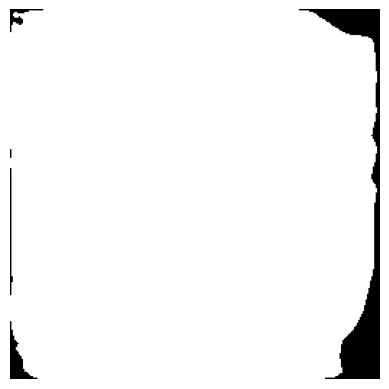

In [8]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Load your image
image_path = "/Users/lionel/Desktop/Research/Processed_Original_cropped_size/T_rgb_20231118_151439_9.png"
image = Image.open(image_path)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the input size expected by the model
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

# Apply transformations
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Assuming model is your pre-trained model
model.eval()  # Set the model to evaluation mode

# If using a GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
input_image = input_image.to(device)

with torch.no_grad():  # No need to track gradients
    output = model(input_image)
    mask = torch.sigmoid(output)  # Apply sigmoid to get probabilities
    mask = (mask > 0.5).float()  # Threshold the probabilities to get binary mask


# Move the mask to CPU and convert to a PIL image
mask = mask.squeeze().cpu()  # Remove batch dimension and move to CPU
mask_image = transforms.ToPILImage()(mask)

# Display the mask using matplotlib
import matplotlib.pyplot as plt

plt.imshow(mask_image, cmap='gray')  # Display the mask
plt.axis('off')  # No axes for cleaner visualization
plt.show()

# Or save the mask to a file
mask_image.save('/Users/lionel/Desktop/Research/duplicate library/test/test5_R_U-Net.png')


In [9]:
import torch

def evaluate_model(dataloader, model, device, threshold=0.5):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Initialize counters
    TP = 0
    FP = 0
    FN = 0
    TN = 0

    with torch.no_grad():
        for images, true_masks in dataloader:
            images = images.to(device)
            true_masks = true_masks.to(device)
            
            # Obtain the model's logits for each image
            logits = model(images)
            
            # Apply sigmoid to convert logits to probabilities
            probs = torch.sigmoid(logits)
            
            # Apply threshold to obtain binary predictions
            preds = probs > threshold
            
            # Flatten the predictions and true values for easier comparison
            preds, true_masks = preds.view(-1), true_masks.view(-1)
            
            # Calculate TP, FP, FN, TN
            TP += ((preds == 1) & (true_masks == 1)).sum().item()
            FP += ((preds == 1) & (true_masks == 0)).sum().item()
            FN += ((preds == 0) & (true_masks == 1)).sum().item()
            TN += ((preds == 0) & (true_masks == 0)).sum().item()

    # Return the confusion matrix components
    return TP, FP, FN, TN


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluate on training data
TP_train, FP_train, FN_train, TN_train = evaluate_model(train_dataloader, model, device)
print(f"Training Data - TP: {TP_train}, FP: {FP_train}, FN: {FN_train}, TN: {TN_train}")

# Evaluate on validation data
TP_val, FP_val, FN_val, TN_val = evaluate_model(val_dataloader, model, device)
print(f"Validation Data - TP: {TP_val}, FP: {FP_val}, FN: {FN_val}, TN: {TN_val}")


Training Data - TP: 11900420, FP: 283256, FN: 267787, TN: 8289012
Validation Data - TP: 5091450, FP: 125643, FN: 121458, TN: 3467659


In [12]:
def calculate_performance_metrics(TP, FP, FN, TN):
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) else 0
    dice_coefficient = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0
    jaccard_index = TP / (TP + FP + FN) if (TP + FP + FN) else 0
    
    return precision, recall, accuracy, dice_coefficient, jaccard_index


precision, recall, accuracy, dice_coefficient, jaccard_index = calculate_performance_metrics(TP_val, FP_val, FN_val, TN_val)

print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Dice Coefficient (F1 Score): {dice_coefficient*100:.2f}%")
print(f"Jaccard Index (IoU): {jaccard_index*100:.2f}%")


Precision: 97.59%
Recall: 97.67%
Accuracy: 97.19%
Dice Coefficient (F1 Score): 97.63%
Jaccard Index (IoU): 95.37%
